In [2]:
import pandas as pd
import numpy as np
df_raw = pd.read_excel('../0_original_data/FAO_Productivity.xlsx')

In [4]:
# 只保留我们需要的列
df = df_raw[['Element', 'Scenario', 'Item', 'Year', 'Value']].copy()

# 转换为数值型，去除缺失
df = df.dropna(subset=['Year', 'Value'])
df['Year'] = df['Year'].astype(int)
df['Value'] = df['Value'].astype(float)

# 创建一个空列表收集结果
records = []

# 获取所有组合
grouped = df.groupby(['Element', 'Scenario', 'Item'])

for (element, scenario, item), group in grouped:
    # 只处理包含2012年的
    if 2012 not in group['Year'].values:
        continue

    # 基准年值
    base_val = group.loc[group['Year'] == 2012, 'Value'].values[0]
    group = group.copy()
    group['Growth_Index'] = group['Value'] / base_val

    # 设置年份范围
    full_years = np.arange(2010, 2051)

    # 构建新索引
    interpolated = pd.DataFrame({'Year': full_years})
    interpolated = interpolated.merge(group[['Year', 'Growth_Index']], on='Year', how='left')

    # 插值（线性）
    interpolated['Growth_Index'] = interpolated['Growth_Index'].interpolate(method='linear')

    # 设置2010和2011为1
    interpolated.loc[interpolated['Year'] < 2012, 'Growth_Index'] = 1.0

    # 添加分组信息
    interpolated['Element'] = element
    interpolated['Scenario'] = scenario
    interpolated['Item'] = item

    records.append(interpolated)

# 汇总所有组数据
df_result = pd.concat(records, ignore_index=True)

In [5]:
# 1. 保留 Irrigated 和 Rainfed 的原始数据
df_irrig_rain = df_result[df_result['Element'].isin(['Irrigated', 'Rainfed'])].copy()

# 2. 处理其他 Element（即非 Irrigated / Rainfed）
df_other = df_result[~df_result['Element'].isin(['Irrigated', 'Rainfed'])].copy()

# 将其他元素统一设为 Irrigated
df_other_irrigated = df_other.copy()
df_other_irrigated['Element'] = 'Irrigated'

# 复制为 Rainfed
df_other_rainfed = df_other.copy()
df_other_rainfed['Element'] = 'Rainfed'

# 3. 合并所有数据
df_result_processed = pd.concat([
    df_irrig_rain,
    df_other_irrigated,
    df_other_rainfed
], ignore_index=True)

In [11]:
print(df_result_processed)
df_result_processed.to_excel('df_result_processed.xlsx', index=False)

      Year  Growth_Index    Element               Scenario                Item
0     2010      1.000000  Irrigated      Business As Usual  Growing of bananas
1     2011      1.000000  Irrigated      Business As Usual  Growing of bananas
2     2012      1.000000  Irrigated      Business As Usual  Growing of bananas
3     2013      1.006949  Irrigated      Business As Usual  Growing of bananas
4     2014      1.013899  Irrigated      Business As Usual  Growing of bananas
...    ...           ...        ...                    ...                 ...
6391  2046      0.769637    Rainfed  Toward Sustainability   Raising of cattle
6392  2047      0.758278    Rainfed  Toward Sustainability   Raising of cattle
6393  2048      0.746918    Rainfed  Toward Sustainability   Raising of cattle
6394  2049      0.735558    Rainfed  Toward Sustainability   Raising of cattle
6395  2050      0.724199    Rainfed  Toward Sustainability   Raising of cattle

[6396 rows x 5 columns]


In [10]:
import pandas as pd
from openpyxl.utils import get_column_letter
import numpy as np

# 定义映射关系（保持不变）
luto_to_fao_mapping = {
    "APPLES": "Growing of other fruits",
    "BEEF - MODIFIED LAND LEXP": "Raising of cattle",
    "BEEF - NATURAL LAND LEXP": "Raising of cattle",
    "BEEF - MODIFIED LAND MEAT": "Raising of cattle",
    "BEEF - NATURAL LAND MEAT": "Raising of cattle",
    "CITRUS": "Growing of citrus fruits",
    "COTTON": "Growing of raw cotton",
    "DAIRY - MODIFIED LAND": "Raising of cattle",
    "DAIRY - NATURAL LAND": "Raising of cattle",
    "GRAPES": "Growing of other fruits",
    "HAY": "Growing of other crops", 
    "NUTS": "Growing of other fruits",
    "OTHER NON-CEREAL CROPS": "Growing of other crops",
    "PEARS": "Growing of other fruits",
    "PLANTATION FRUIT": "Growing of other fruits",
    "RICE": "Growing of paddy rice",
    "SHEEP - MODIFIED LAND LEXP": "Raising of sheep",
    "SHEEP - MODIFIED LAND MEAT": "Raising of sheep",
    "SHEEP - MODIFIED LAND WOOL": "Raising of sheep",
    "SHEEP - NATURAL LAND LEXP": "Raising of sheep",
    "SHEEP - NATURAL LAND MEAT": "Raising of sheep",
    "SHEEP - NATURAL LAND WOOL": "Raising of sheep",
    "STONE FRUIT": "Growing of other fruits",
    "SUGAR": "Growing of sugar cane",
    "SUMMER CEREALS": "Growing of grain maize",
    "SUMMER LEGUMES": "Growing of soybeans",
    "SUMMER OILSEEDS": "Growing of sunflower seed",
    "TROPICAL STONE FRUIT": "Growing of bananas",
    "VEGETABLES": "Growing of other vegetables",
    "WINTER CEREALS": "Growing of wheat",
    "WINTER LEGUMES": "Growing of dried pulses",
    "WINTER OILSEEDS": "Growing of rape and mustardseed"
}

element_mapping = {
    'Irrigated': 'irr',
    'Rainfed': 'dry'
}

# 创建反向映射
fao_to_luto_mapping = {}
for luto, fao in luto_to_fao_mapping.items():
    if fao not in fao_to_luto_mapping:
        fao_to_luto_mapping[fao] = []
    fao_to_luto_mapping[fao].append(luto)

# LUTO 项目顺序（保持不变）
luto_order = [
    "APPLES", "BEEF - MODIFIED LAND LEXP", "BEEF - NATURAL LAND LEXP", 
    "BEEF - MODIFIED LAND MEAT", "BEEF - NATURAL LAND MEAT", "CITRUS", 
    "COTTON", "DAIRY - MODIFIED LAND", "DAIRY - NATURAL LAND", "GRAPES", 
    "HAY", "NUTS", "OTHER NON-CEREAL CROPS", "PEARS", "PLANTATION FRUIT", 
    "RICE", "SHEEP - MODIFIED LAND LEXP", "SHEEP - MODIFIED LAND MEAT", 
    "SHEEP - MODIFIED LAND WOOL", "SHEEP - NATURAL LAND LEXP", 
    "SHEEP - NATURAL LAND MEAT", "SHEEP - NATURAL LAND WOOL", "STONE FRUIT", 
    "SUGAR", "SUMMER CEREALS", "SUMMER LEGUMES", "SUMMER OILSEEDS", 
    "TROPICAL STONE FRUIT", "UNALLOCATED - MODIFIED LAND", 
    "UNALLOCATED - NATURAL LAND", "VEGETABLES", "WINTER CEREALS", 
    "WINTER LEGUMES", "WINTER OILSEEDS"
]


# 准备数据
df_temp = df_result_processed.copy()

# 改进映射逻辑：为每个 FAO 项生成所有对应的 LUTO 项
expanded_rows = []
for _, row in df_temp.iterrows():
    if row['Item'] in fao_to_luto_mapping:
        for luto_item in fao_to_luto_mapping[row['Item']]:
            new_row = row.copy()
            new_row['LUTO_Item'] = luto_item
            expanded_rows.append(new_row)
    else:
        new_row = row.copy()
        new_row['LUTO_Item'] = row['Item'] if 'UNALLOCATED' in str(row['Item']) else 'UNKNOWN'
        expanded_rows.append(new_row)

df_temp = pd.DataFrame(expanded_rows)

# 映射 Element
df_temp['Water_Type'] = df_temp['Element'].map(element_mapping)

# 获取所有唯一的 Scenario 和 Year
scenarios = df_temp['Scenario'].unique()
all_years = sorted(df_temp['Year'].unique())

print(f"发现 {len(scenarios)} 个场景: {scenarios}")
print(f"年份范围: {min(all_years)} - {max(all_years)}")

# 检查哪些 LUTO 项目在数据中存在
existing_luto_items = set(df_temp['LUTO_Item'].dropna().unique())
print(f"\n数据中存在的 LUTO 项目数: {len(existing_luto_items)}")
missing_luto_items = set(luto_order) - existing_luto_items
print(f"缺失的 LUTO 项目数: {len(missing_luto_items)}")
print(f"缺失的项目: {sorted(missing_luto_items)}")

# 创建 Excel Writer
output_file = 'output_by_scenario.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for scenario in scenarios:
        print(f"\n处理场景: {scenario}")
        
        df_scenario = df_temp[df_temp['Scenario'] == scenario].copy()
        
        # 调试：检查每个场景的数据
        print(f"场景 {scenario} 的记录数: {len(df_scenario)}")
        print(f"场景 {scenario} 的 LUTO_Item 唯一值: {df_scenario['LUTO_Item'].unique()}")
        print(f"场景 {scenario} 的 Water_Type 唯一值: {df_scenario['Water_Type'].unique()}")
        
        # 创建透视表
        pivot_df = df_scenario.pivot_table(
            index='Year',
            columns=['Water_Type', 'LUTO_Item'],
            values='Growth_Index',
            aggfunc='first'
        )
        
        # 调试：检查透视表列
        print(f"场景 {scenario} 的透视表列数: {len(pivot_df.columns)}")
        print(f"透视表列名: {pivot_df.columns.tolist()}")
        
        # 创建完整的 DataFrame
        data_dict = {'Year': all_years}
        for water_type in ['dry', 'irr']:
            for luto_item in luto_order:
                col_name = f"{water_type}_{luto_item}"
                if (water_type, luto_item) in pivot_df.columns:
                    data_dict[col_name] = pivot_df[(water_type, luto_item)].reindex(all_years).values
                else:
                    data_dict[col_name] = [1.0] * len(all_years)
        
        df_flat = pd.DataFrame(data_dict)
        
        # 清理 sheet 名称
        sheet_name = scenario[:31].replace('/', '-').replace('\\', '-').replace('*', '-')
        sheet_name = sheet_name.replace('[', '(').replace(']', ')').replace(':', '-').replace('?', '').strip()
        
        print(f"  写入 sheet: {sheet_name}")
        print(f"  数据形状: {df_flat.shape}")
        
        # 写入数据（不包含列名）
        df_flat.to_excel(writer, sheet_name=sheet_name, index=False, header=False, startrow=2)
        
        # 获取工作表
        worksheet = writer.sheets[sheet_name]
        
        # 手动写入两级表头
        col_idx = 1
        worksheet.cell(1, col_idx, 'Year')
        worksheet.cell(2, col_idx, 'Year')
        col_idx += 1
        
        for water_type in ['dry', 'irr']:
            for luto_item in luto_order:
                worksheet.cell(1, col_idx, water_type)
                worksheet.cell(2, col_idx, luto_item)
                col_idx += 1
        
        # 调整列宽
        for i in range(1, df_flat.shape[1] + 1):
            col_letter = get_column_letter(i)
            worksheet.column_dimensions[col_letter].width = 20

print(f"\n✅ 完成！结果已保存到: {output_file}")


原始数据的 Item 唯一值：
['Growing of bananas' 'Growing of barley' 'Growing of citrus fruits'
 'Growing of dried pulses' 'Growing of grain maize'
 'Growing of groundnuts' 'Growing of millet' 'Growing of other cereals'
 'Growing of other crops' 'Growing of other fruits'
 'Growing of other oilseeds' 'Growing of other vegetables'
 'Growing of paddy rice' 'Growing of potatoes'
 'Growing of rape and mustardseed' 'Growing of raw cotton'
 'Growing of sorghum' 'Growing of soybeans' 'Growing of sugar cane'
 'Growing of sunflower seed' 'Growing of sweet potato and yams'
 'Growing of tobacco' 'Growing of wheat' 'Growing of olives'
 'Raising of cattle' 'Raising of goats' 'Raising of sheep'
 'Raising of pigs' 'Raising of poultry']
原始数据的 Element 唯一值：
['Irrigated' 'Rainfed']
Growth_Index 空值统计：
0
映射后的 LUTO_Item 唯一值：
['TROPICAL STONE FRUIT' 'UNKNOWN' 'CITRUS' 'WINTER LEGUMES'
 'SUMMER CEREALS' 'HAY' 'OTHER NON-CEREAL CROPS' 'APPLES' 'GRAPES' 'NUTS'
 'PEARS' 'PLANTATION FRUIT' 'STONE FRUIT' 'VEGETABLES' 'RICE'
 

In [15]:
df_temp

Year  Growth_Index    Element               Scenario  \
0     2010      1.000000  Irrigated      Business As Usual   
1     2011      1.000000  Irrigated      Business As Usual   
2     2012      1.000000  Irrigated      Business As Usual   
3     2013      1.006949  Irrigated      Business As Usual   
4     2014      1.013899  Irrigated      Business As Usual   
...    ...           ...        ...                    ...   
6395  2050      0.724199    Rainfed  Toward Sustainability   
6395  2050      0.724199    Rainfed  Toward Sustainability   
6395  2050      0.724199    Rainfed  Toward Sustainability   
6395  2050      0.724199    Rainfed  Toward Sustainability   
6395  2050      0.724199    Rainfed  Toward Sustainability   

                    Item                  LUTO_Item Water_Type  
0     Growing of bananas       TROPICAL STONE FRUIT        irr  
1     Growing of bananas       TROPICAL STONE FRUIT        irr  
2     Growing of bananas       TROPICAL STONE FRUIT        irr  
3     Growing of bananas       TROPICAL STONE FRUIT        irr  
4     Growing of bananas       TROPICAL STONE FRUIT        irr  
...                  ...                        ...        ...  
6395   Raising of cattle   BEEF - NATURAL LAND LEXP        dry  
6395   Raising of cattle  BEEF - MODIFIED LAND MEAT        dry  
6395   Raising of cattle   BEEF - NATURAL LAND MEAT        dry  
6395   Raising of cattle      DAIRY - MODIFIED LAND        dry  
6395   Raising of cattle       DAIRY - NATURAL LAND        dry  

[11562 rows x 7 columns]

✅ 保存图像: growth_index_Business As Usual.png


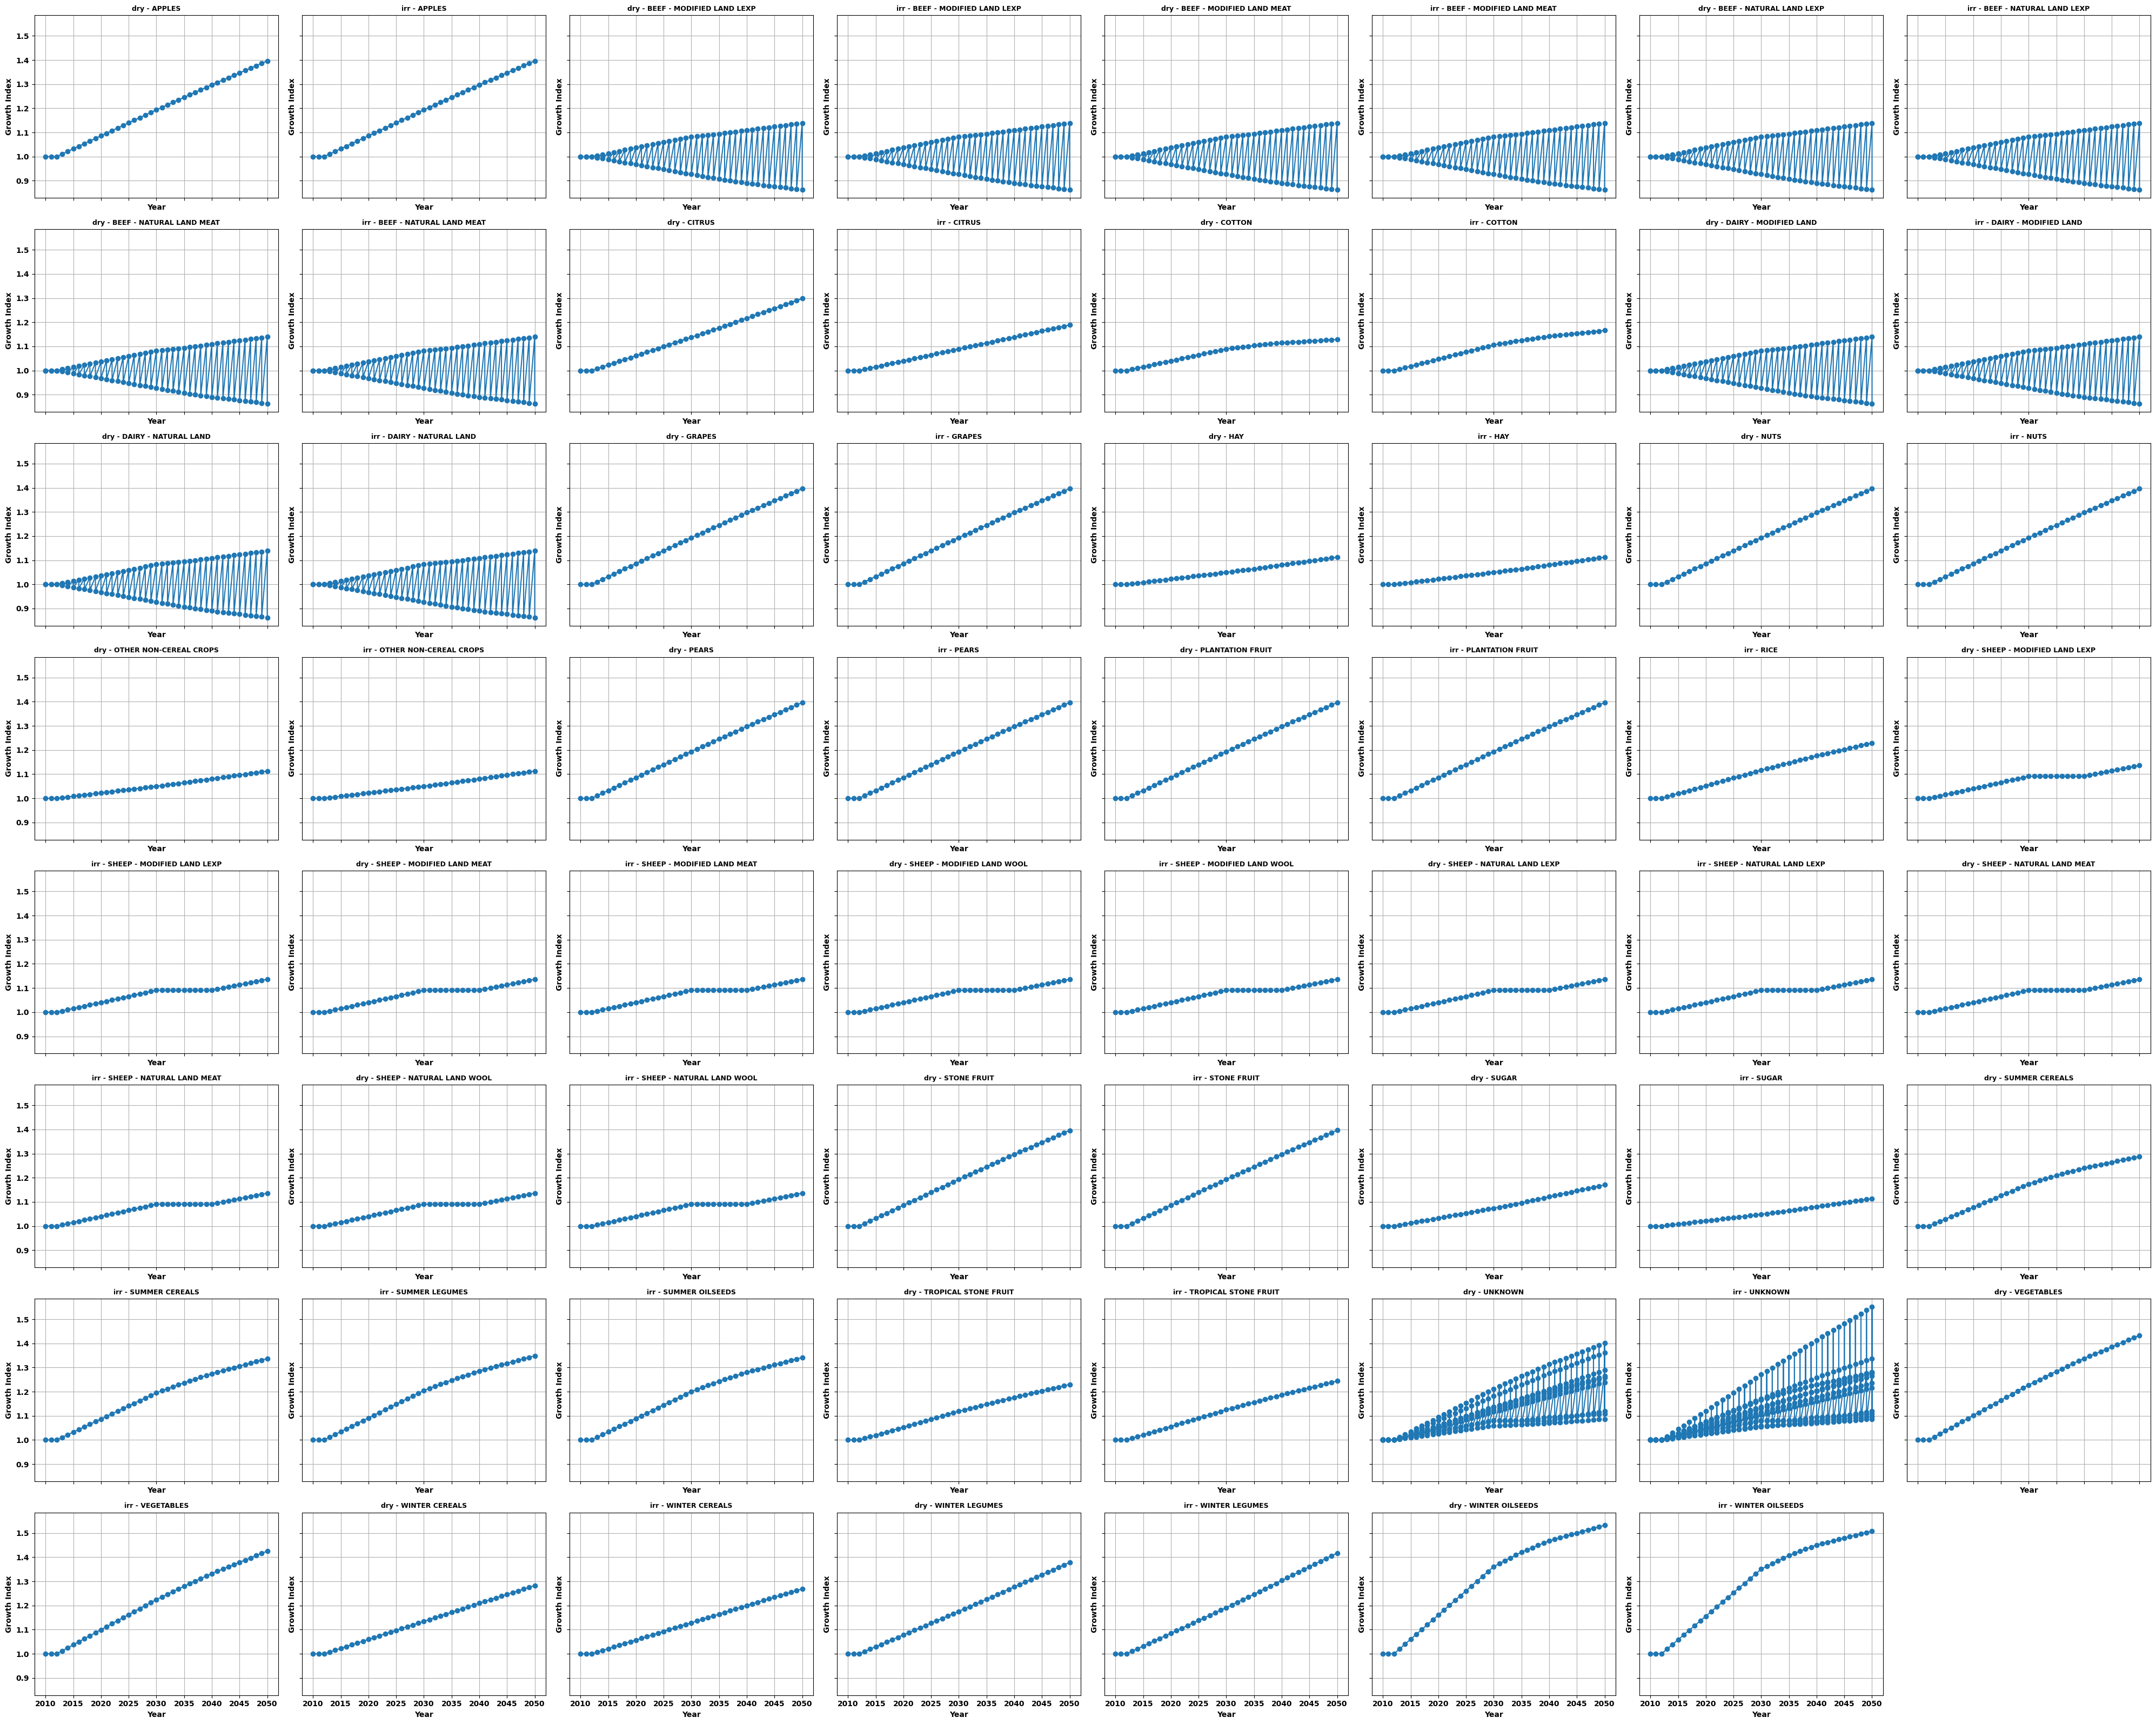

✅ 保存图像: growth_index_Stratified Societies.png


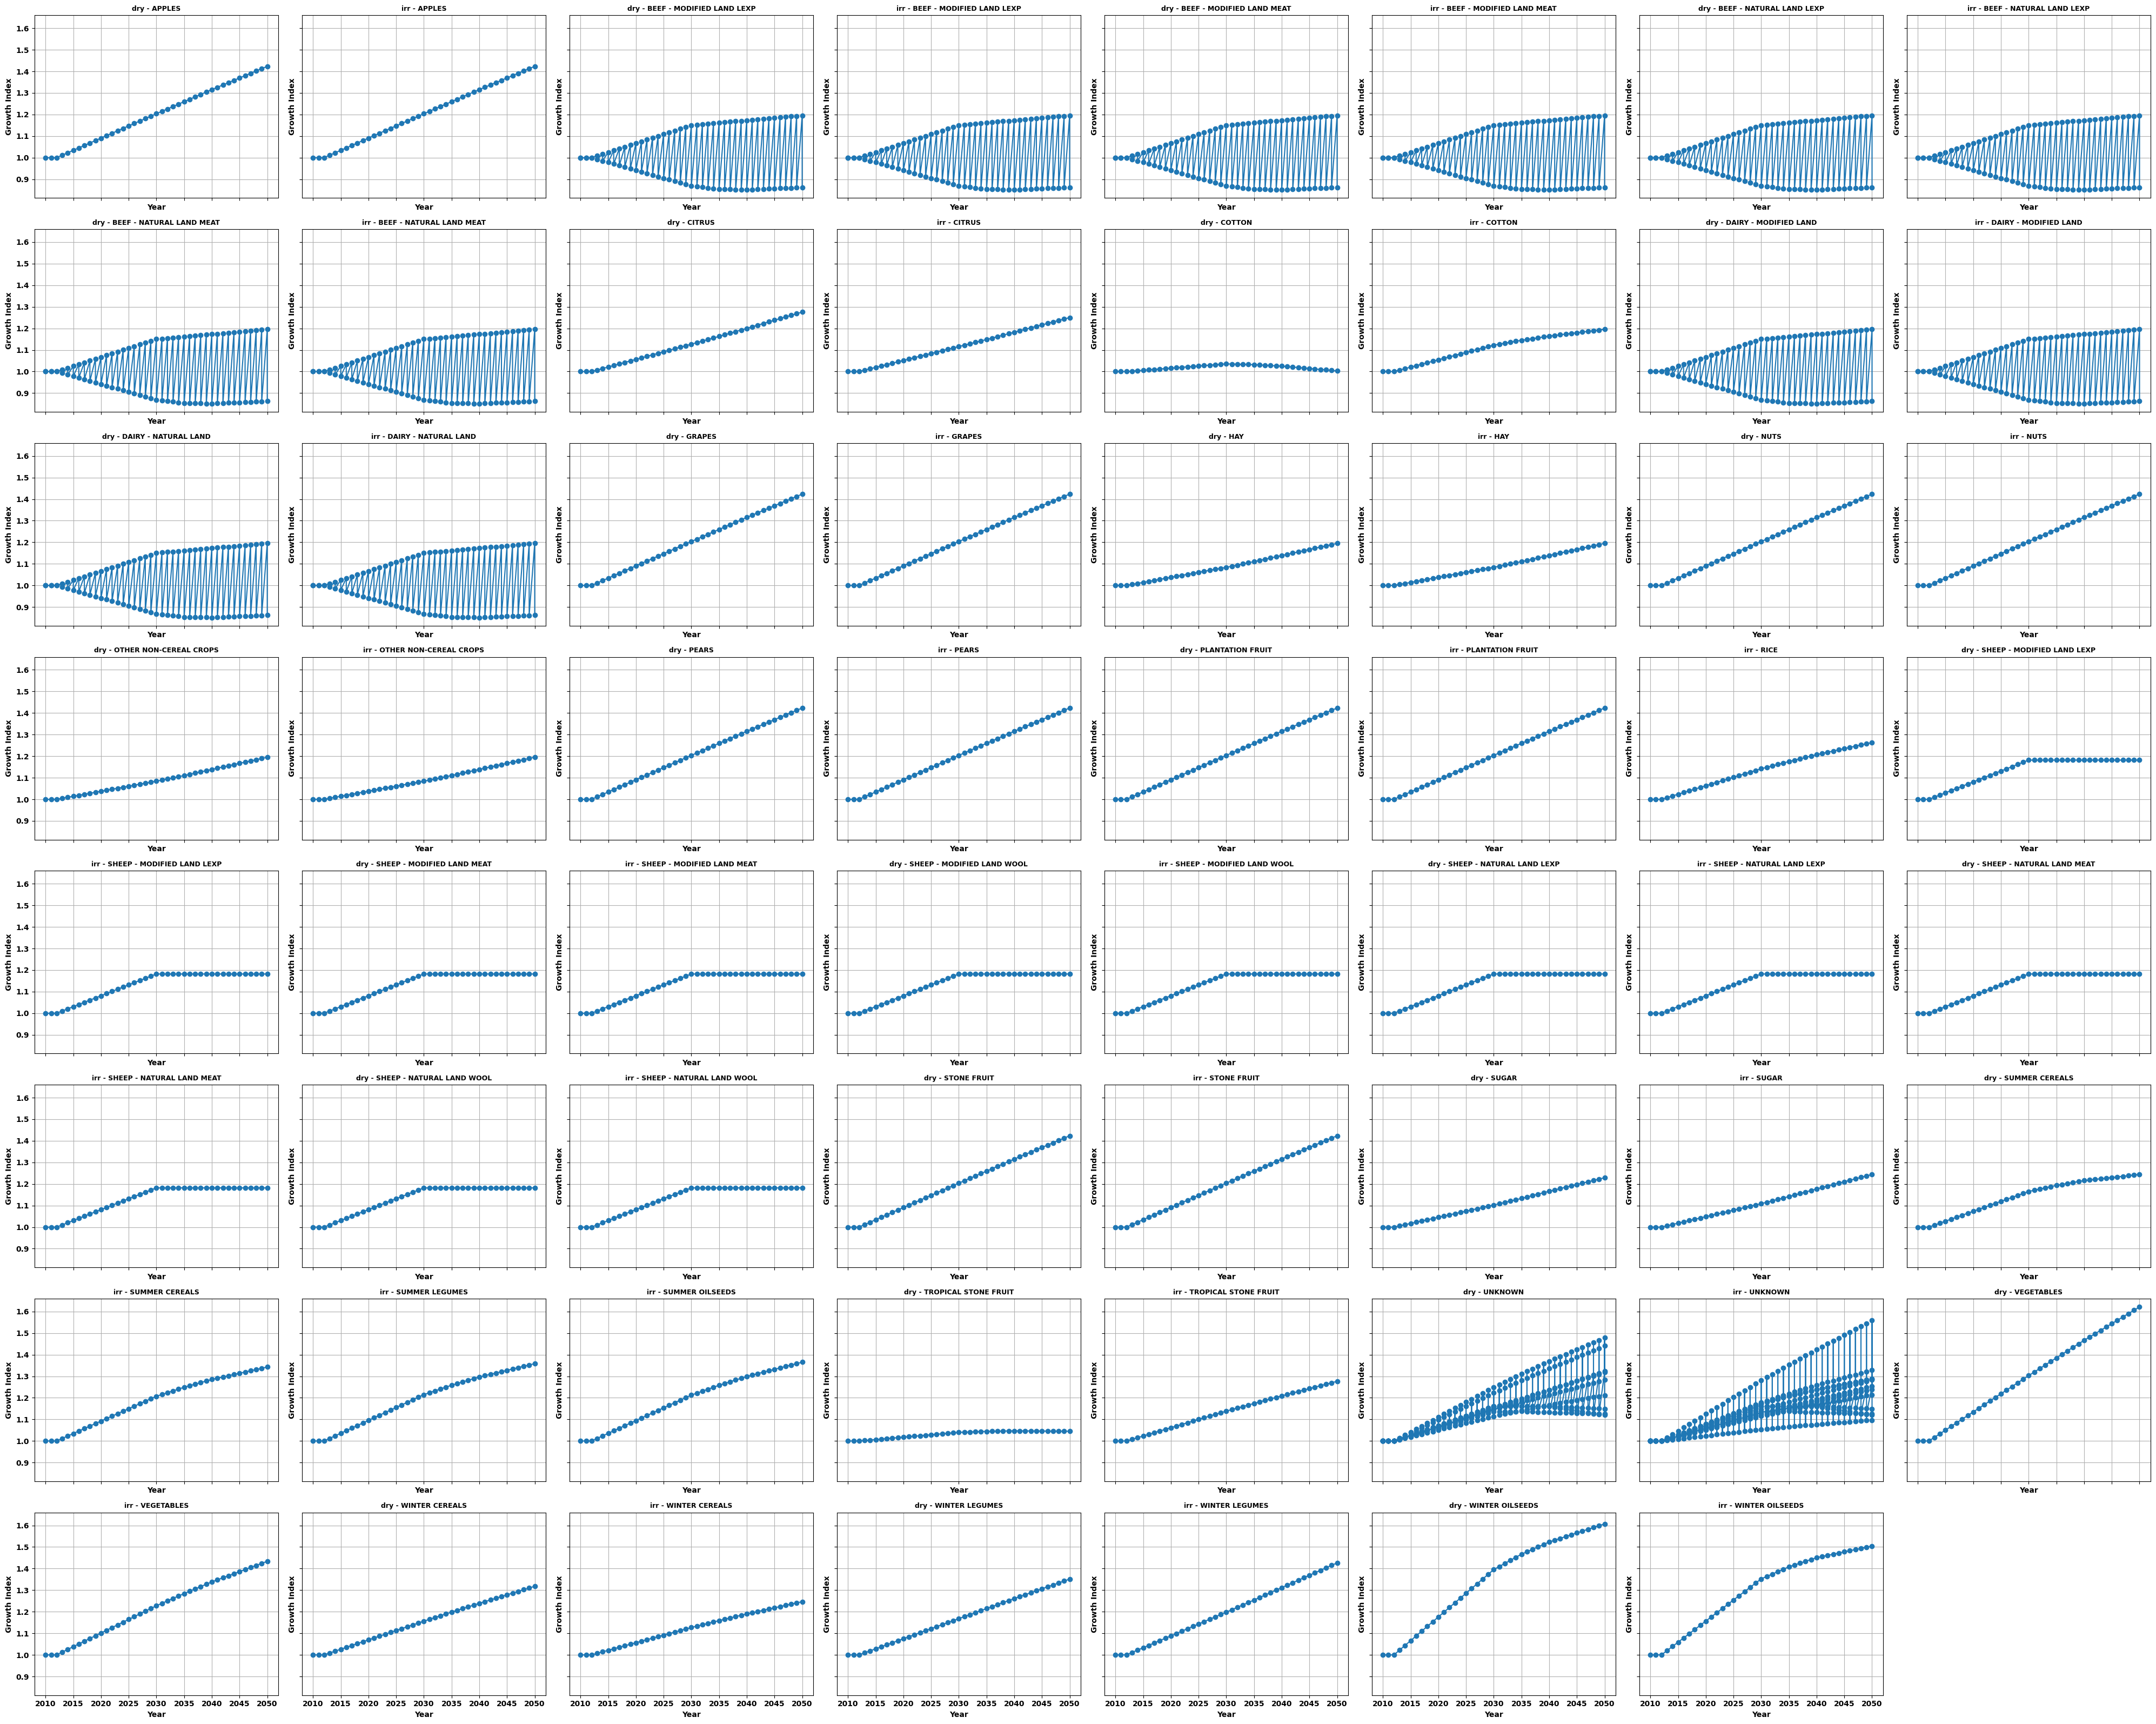

✅ 保存图像: growth_index_Toward Sustainability.png


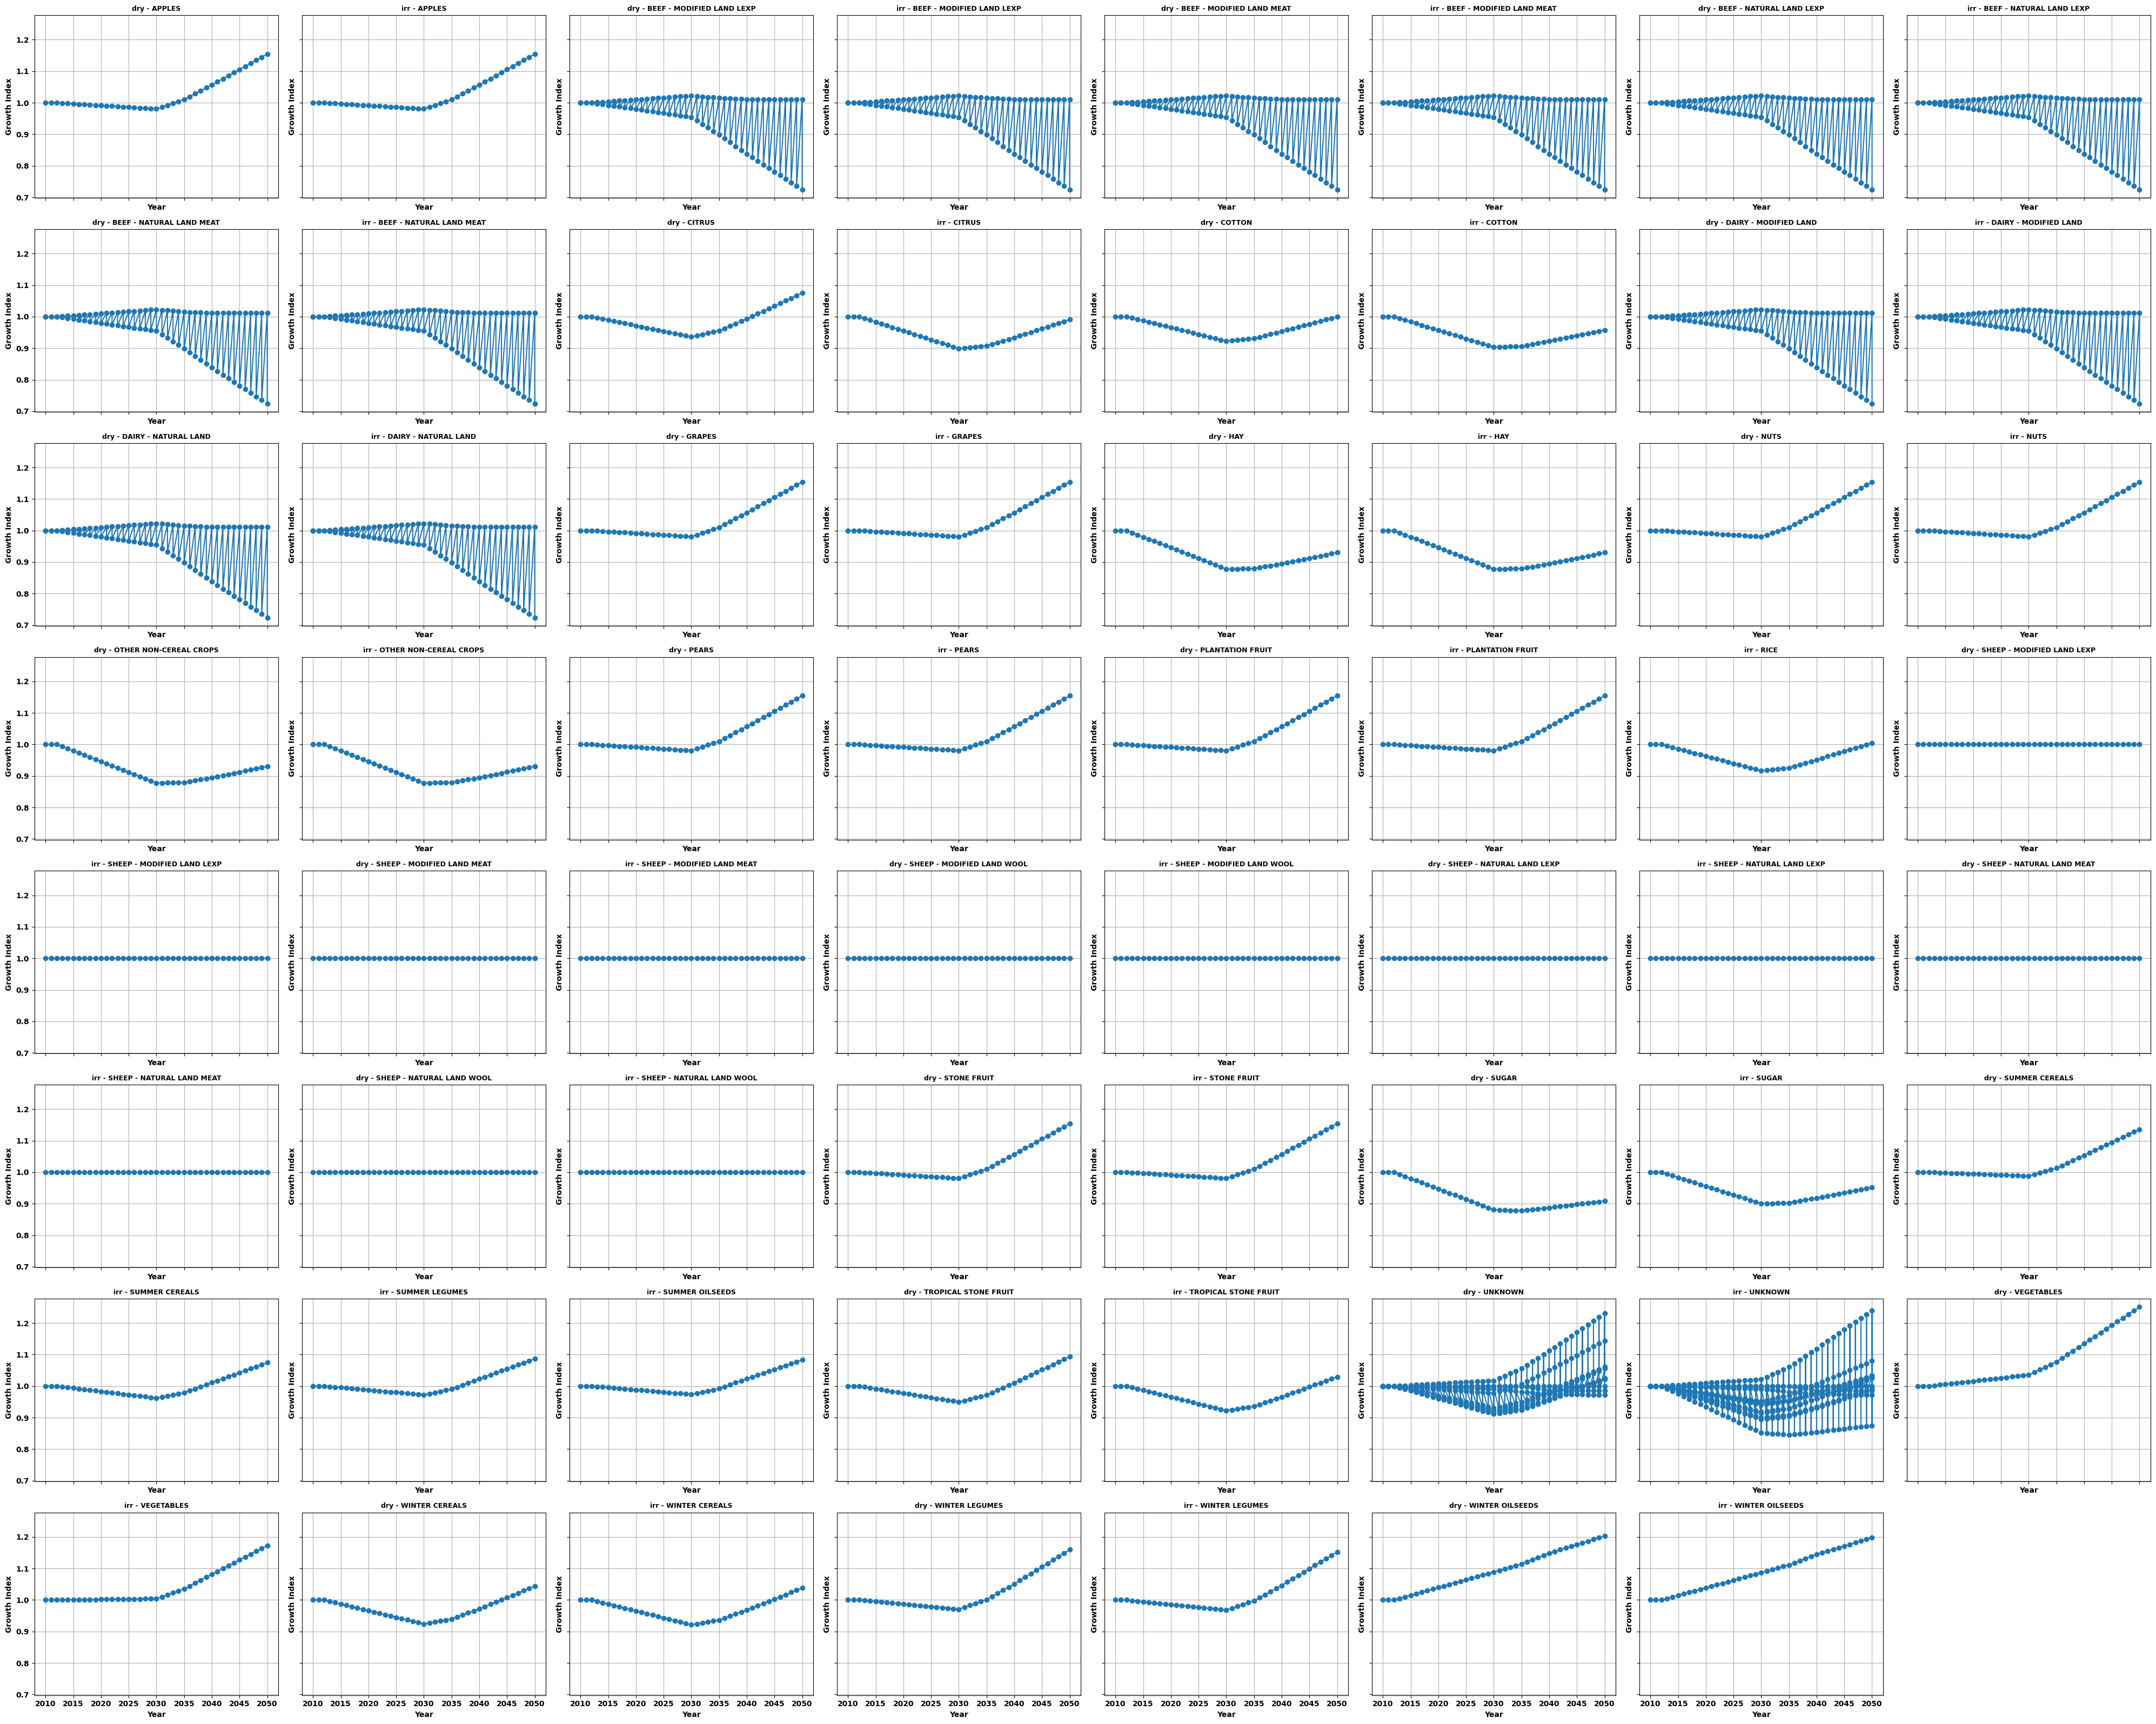

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 保证排序一致性
df_temp_sorted = df_temp.sort_values(by=['Scenario', 'LUTO_Item', 'Water_Type', 'Year'])

# 获取所有 Scenario
scenarios = df_temp_sorted['Scenario'].unique()

# 循环每个 Scenario 分开画图
for scenario in scenarios:
    df_scen = df_temp_sorted[df_temp_sorted['Scenario'] == scenario]
    
    # 分组
    grouped = df_scen.groupby(['LUTO_Item', 'Water_Type'])
    n_plots = len(grouped)
    n_cols = 8
    n_rows = (n_plots + n_cols - 1) // n_cols

    # 创建图形
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, n_rows * 4), sharex=True, sharey=True)
    axes = axes.flatten()

    # 绘制每个子图
    for ax, ((luto_item, water_type), group) in zip(axes, grouped):
        ax.plot(group['Year'], group['Growth_Index'], marker='o', linestyle='-')
        ax.set_title(f"{water_type} - {luto_item}", fontsize=9)
        ax.set_xlabel("Year")
        ax.set_ylabel("Growth Index")
        ax.grid(True)

    # 删除空子图
    for i in range(len(grouped), len(axes)):
        fig.delaxes(axes[i])

    # 布局调整 & 保存
    plt.tight_layout()
    safe_scenario_name = scenario.replace('/', '-').replace('\\', '-').replace(':', '-')
    filename = f"growth_index_{safe_scenario_name}.png"
    plt.savefig(filename, dpi=1000)
    print(f"✅ 保存图像: {filename}")
    plt.show()

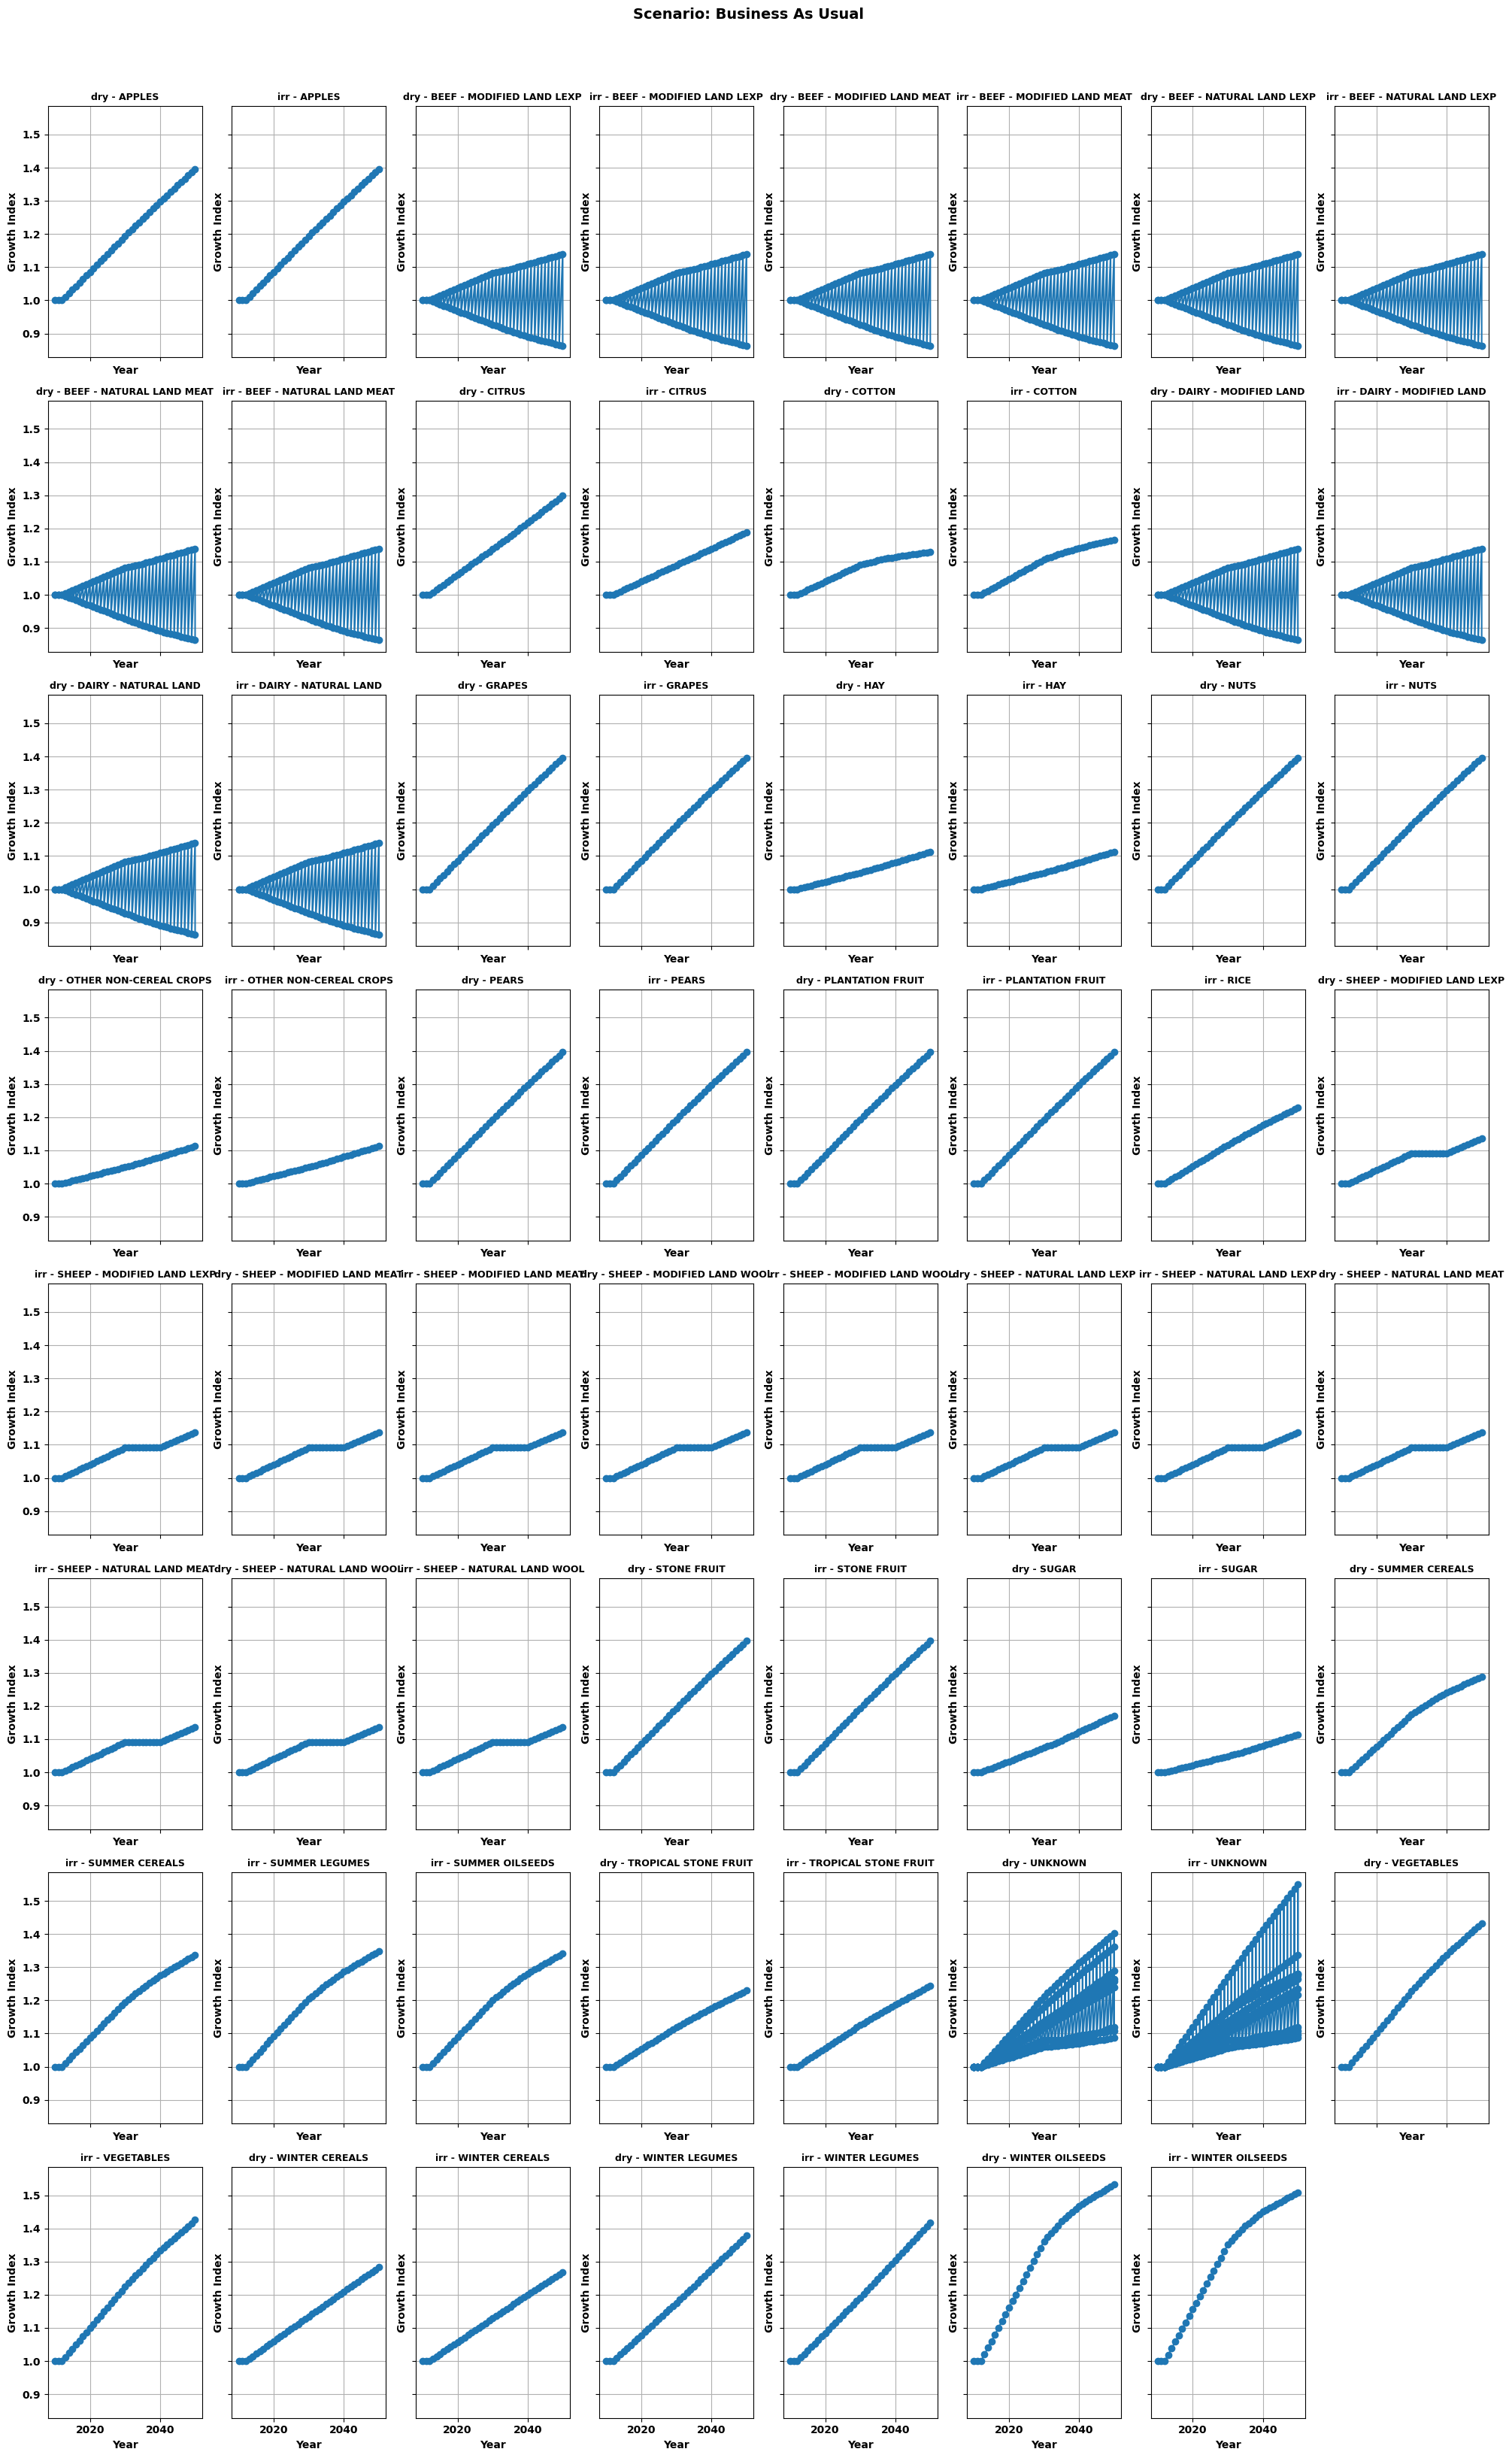

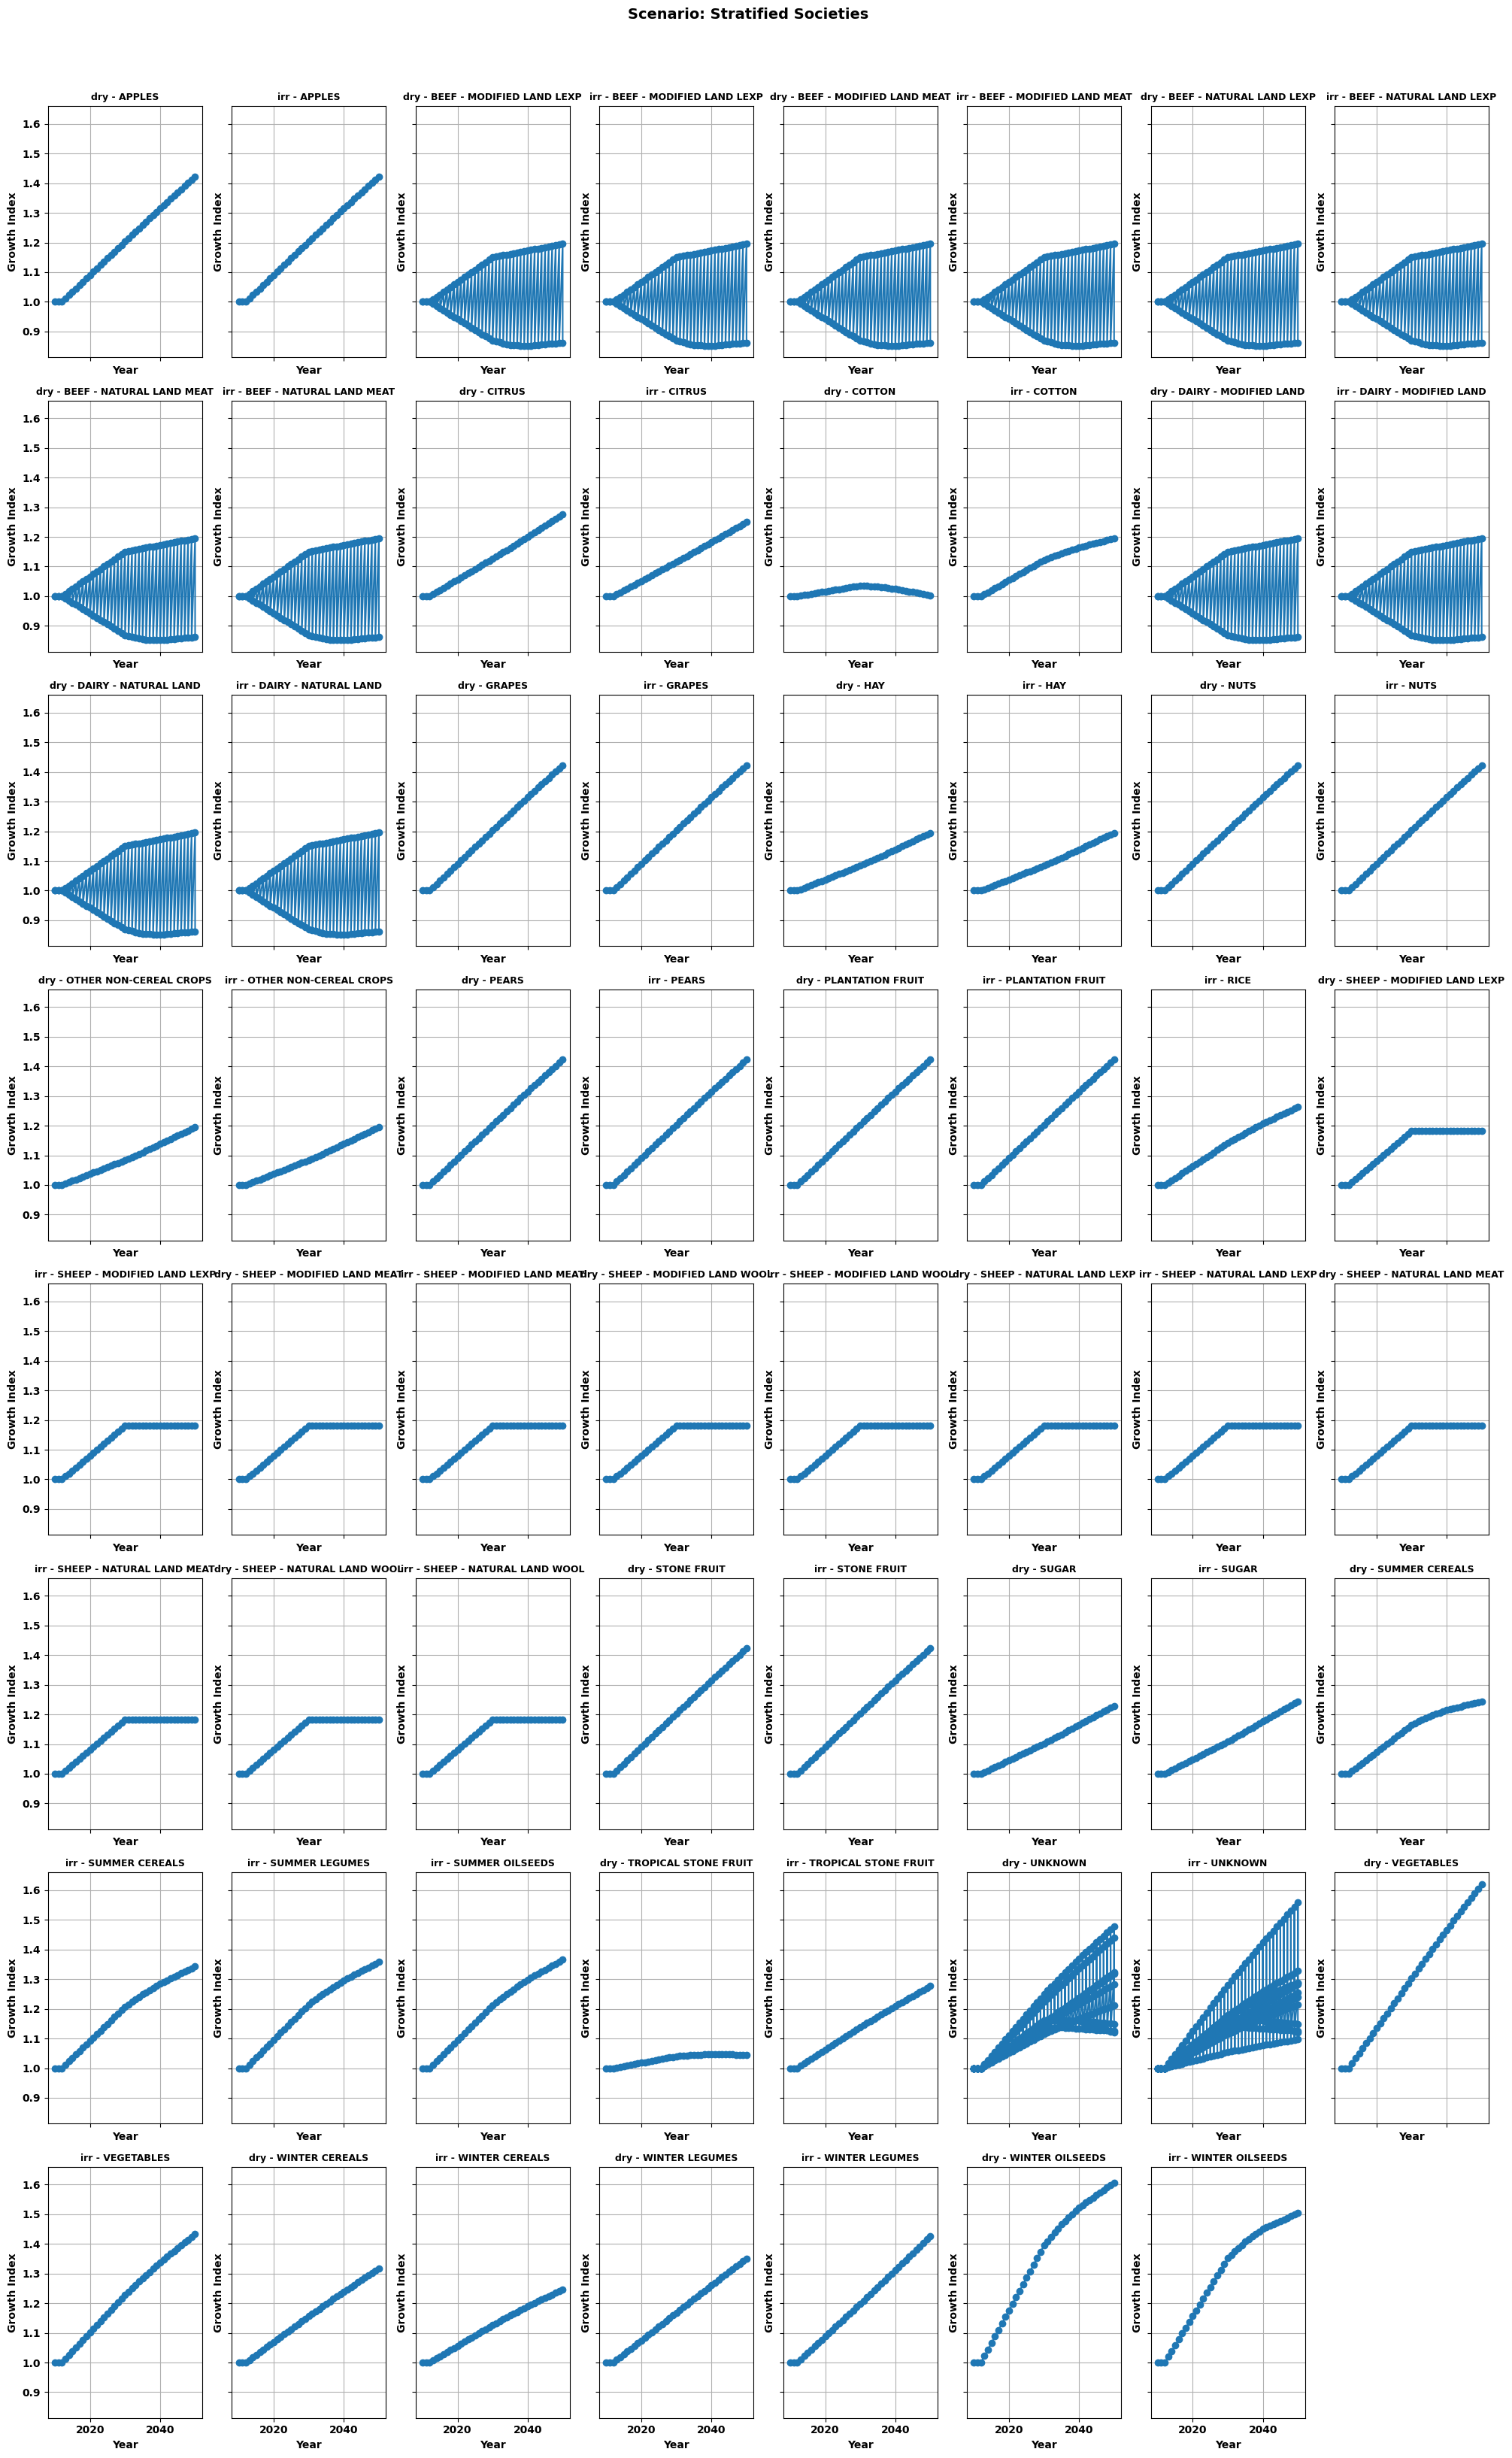

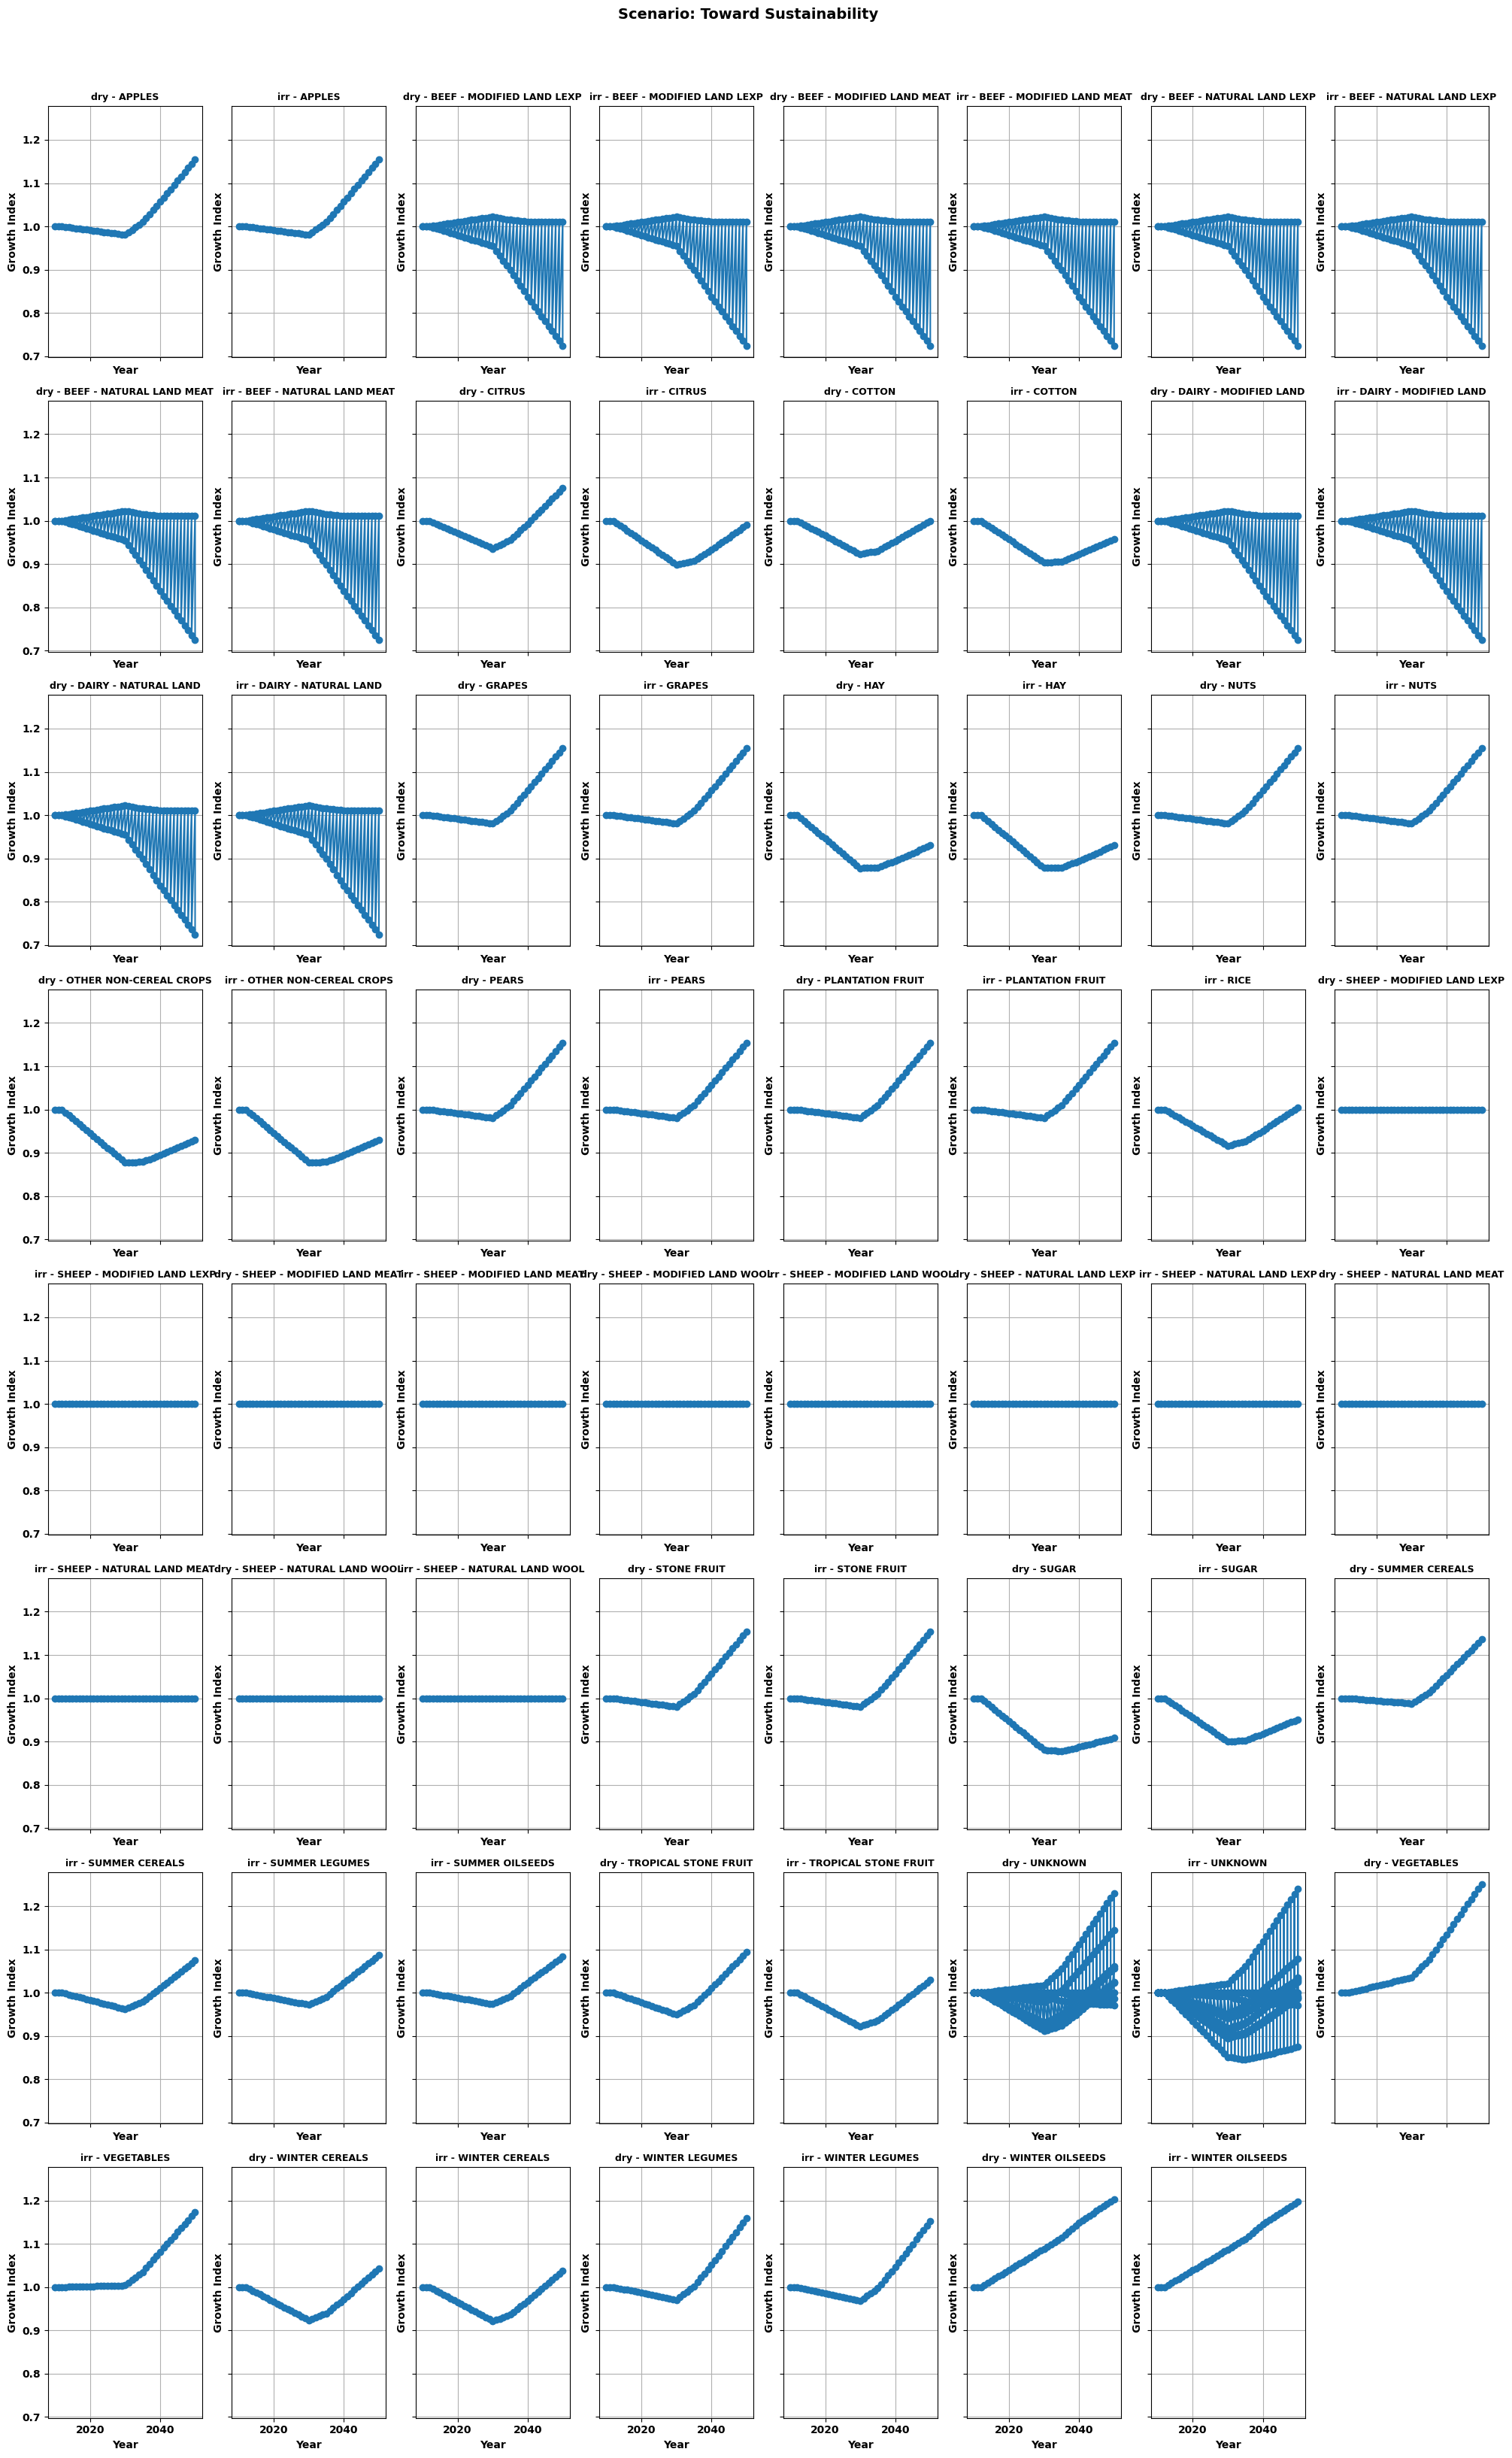

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 保证排序一致性
df_temp_sorted = df_temp.sort_values(by=['Scenario', 'LUTO_Item', 'Water_Type', 'Year'])

# 获取所有场景
scenarios = df_temp_sorted['Scenario'].unique()

# 为每个场景创建单独的图形
for scenario in scenarios:
    # 筛选当前场景的数据
    df_scenario = df_temp_sorted[df_temp_sorted['Scenario'] == scenario]
    
    # 按 LUTO_Item 和 Water_Type 分组
    grouped = df_scenario.groupby(['LUTO_Item', 'Water_Type'])
    
    # 设置子图布局参数
    n_plots = len(grouped)
    n_cols = 8
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # 创建图形和子图
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4), sharex=True, sharey=True)
    axes = axes.flatten() if n_plots > 1 else [axes]  # 确保单子图时也能迭代
    
    # 绘图
    for ax, ((luto_item, water_type), group) in zip(axes, grouped):
        ax.plot(group['Year'], group['Growth_Index'], marker='o', linestyle='-')
        ax.set_title(f"{water_type} - {luto_item}", fontsize=9)
        ax.set_xlabel("Year")
        ax.set_ylabel("Growth Index")
        ax.grid(True)
    
    # 删除多余空白子图
    for i in range(len(grouped), len(axes)):
        fig.delaxes(axes[i])
    
    # 设置主标题
    fig.suptitle(f"Scenario: {scenario}", fontsize=14, y=1.02)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图形（可选）
    plt.savefig(f"plot_scenario_{scenario.replace('/', '-')}.png", bbox_inches='tight')
    
    # 显示图形
    plt.show()